<h2 style='color:blue' align='center'>Celebrity Image Classification<h2>

In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

<h3 style='color:purple'>Preprocessing 1: Detect face and eyes</h3>

we used inbuild fuctions of open cv to detect eyes, nose and face

In [2]:
img = cv2.imread('./test_images/messi.jpg')
img.shape

(500, 400, 3)

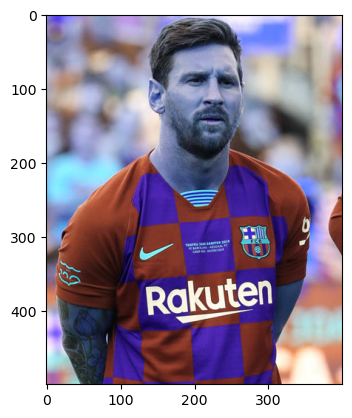

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(500, 400)

In [5]:
gray

array([[176, 172, 167, ..., 225, 228, 230],
       [174, 171, 165, ..., 224, 226, 229],
       [172, 168, 162, ..., 220, 223, 226],
       ...,
       [137, 137, 137, ..., 169, 177, 182],
       [137, 137, 137, ..., 162, 170, 175],
       [137, 137, 137, ..., 156, 164, 170]], dtype=uint8)

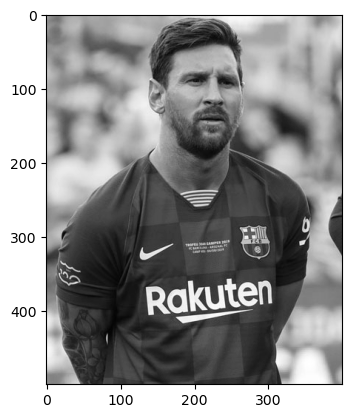

In [6]:
plt.imshow(gray, cmap='gray')

In [7]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[165,  43, 122, 122]])

In [8]:
(x,y,w,h) = faces[0]
x,y,w,h

(165, 43, 122, 122)

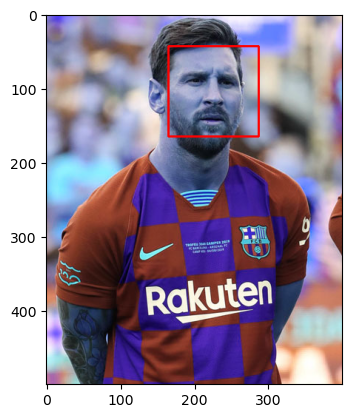

In [9]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

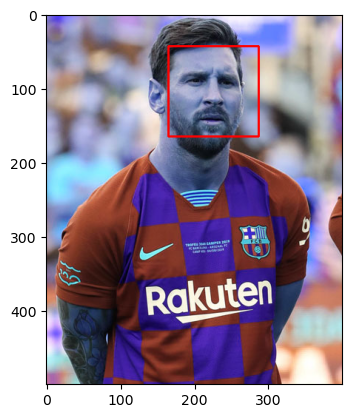

In [10]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

<h3 style='color:purple'>Preprocessing 2: Crop the face of the image</h3>

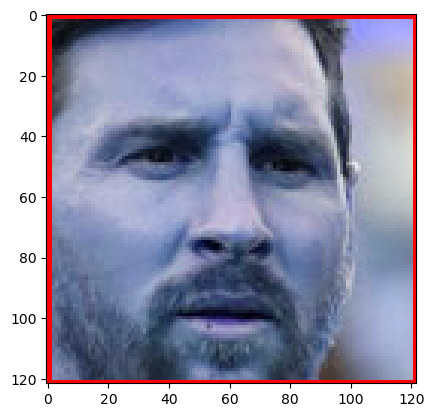

In [11]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [12]:
cropped_img = np.array(roi_color)
cropped_img.shape

(122, 122, 3)

<h3 style='color:purple'>Preprocessing 3 : Use wavelet transform to get more accurate facial data points to train model</h3>

#### In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc

### Wavelet transform

In [13]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=5):
    imArray = img
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    coeffs=pywt.wavedec2(imArray, mode, level=level)
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

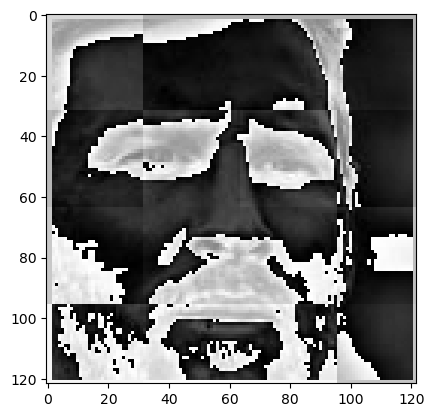

In [14]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

#### we can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

<h3 style='color:purple'>Preprocessing 3: Load image, detect face. If eyes >=2, then save and crop the face region</h3>

####  Lets write a python function that can take input image and returns cropped image (if face and eyes >=2 are detected)

In [15]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

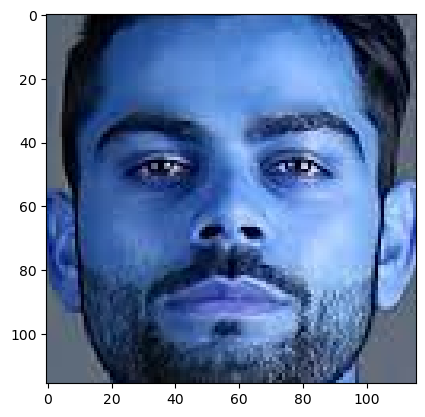

In [21]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/virat_kohli.jpg')
plt.imshow(cropped_image)

In [22]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/sharapova2.jpg')
cropped_image_no_2_eyes

nothing printed in above cell because 2 eyes are not detected

In [23]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [29]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [30]:
img_dirs

['./dataset/lionel_messi',
 './dataset/maria_sharapova',
 './dataset/roger_federer',
 './dataset/serena_williams',
 './dataset/virat_kohli']

**Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code**

In [31]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [32]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./dataset/cropped/lionel_messi
Generating cropped images in folder:  ./dataset/cropped/maria_sharapova
Generating cropped images in folder:  ./dataset/cropped/roger_federer
Generating cropped images in folder:  ./dataset/cropped/serena_williams
Generating cropped images in folder:  ./dataset/cropped/virat_kohli


In [33]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'lionel_messi': ['./dataset/cropped/lionel_messi\\lionel_messi1.png',
  './dataset/cropped/lionel_messi\\lionel_messi10.png',
  './dataset/cropped/lionel_messi\\lionel_messi11.png',
  './dataset/cropped/lionel_messi\\lionel_messi12.png',
  './dataset/cropped/lionel_messi\\lionel_messi13.png',
  './dataset/cropped/lionel_messi\\lionel_messi14.png',
  './dataset/cropped/lionel_messi\\lionel_messi15.png',
  './dataset/cropped/lionel_messi\\lionel_messi16.png',
  './dataset/cropped/lionel_messi\\lionel_messi17.png',
  './dataset/cropped/lionel_messi\\lionel_messi18.png',
  './dataset/cropped/lionel_messi\\lionel_messi19.png',
  './dataset/cropped/lionel_messi\\lionel_messi2.png',
  './dataset/cropped/lionel_messi\\lionel_messi20.png',
  './dataset/cropped/lionel_messi\\lionel_messi21.png',
  './dataset/cropped/lionel_messi\\lionel_messi22.png',
  './dataset/cropped/lionel_messi\\lionel_messi23.png',
  './dataset/cropped/lionel_messi\\lionel_messi24.png',
  './dataset/cropped/lionel_messi\

In [34]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

### Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. 

Let's prepare X and y now

In [35]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [36]:
len(X[0])
#32*32*3 + 32*32

4096

In [37]:
X[0].shape

(4096, 1)

In [38]:
y[10]

0

In [39]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(177, 4096)

### training our model

We will use logistic regression along with StandardScaler

In [40]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(C=1, solver='liblinear'))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8

In [42]:
best_clf = pipe
best_clf
# LogisticRegression(C=1, solver='liblinear')
# SVC(C=1, gamma='auto', kernel='linear', probability=True)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lr', LogisticRegression(C=1, solver='liblinear'))])

In [43]:
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

## creating functions to preprocess the input image before classcification

In [44]:
def get_cropped_image_if_2_eyes_2(img):
    #img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [45]:
def prepare_to_predict(img):
        #img = cv2.imread(test_img)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        img_p_array = []
        img_p_array.append(combined_img)
        to_retrn = np.array(img_p_array).reshape(len(img_p_array),4096).astype(float)
        return to_retrn

## using gradio as front-end for image classsification

In [46]:
import gradio as gr

def classify_image(test_img):
    temp = get_cropped_image_if_2_eyes_2(test_img)
    if temp is not None:
        temp2 = prepare_to_predict(temp)
        output = list(class_dict.keys())[list(class_dict.values()).index(pipe.predict(temp2)[0])]
        return "This is " + output
    else:
         return 'face is not detected, try with other image'

demo = gr.Interface(fn=classify_image, inputs="image", outputs="text")
    
if __name__ == "__main__":
    demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "C:\Users\Akshay L Telang\AppData\Roaming\Python\Python39\site-packages\gradio\routes.py", line 414, in run_predict
    output = await app.get_blocks().process_api(
  File "C:\Users\Akshay L Telang\AppData\Roaming\Python\Python39\site-packages\gradio\blocks.py", line 1320, in process_api
    result = await self.call_function(
  File "C:\Users\Akshay L Telang\AppData\Roaming\Python\Python39\site-packages\gradio\blocks.py", line 1048, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "C:\ProgramData\Anaconda3\lib\site-packages\anyio\to_thread.py", line 28, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(func, *args, cancellable=cancellable,
  File "C:\ProgramData\Anaconda3\lib\site-packages\anyio\_backends\_asyncio.py", line 818, in run_sync_in_worker_thread
    return await future
  File "C:\ProgramData\Anaconda3\lib\site-packages\anyio\_backends\_asyncio.py", line 754, in run
    result = context.run